# Interactive art with ipywidgets and vsketch

By [Allison Parrish](http://www.decontextualize.com/)

This notebook shows how to add interactivity to Python code that produces visual output with [vsketch](https://vsketch.readthedocs.io/en/latest/index.html). It's meant to accompany course material in [Computational Letterforms and Layout](https://cll.decontextualize.com/), but my hope is it will be valuable to anyone who wants to learn the basics of [ipywidgets](https://github.com/jupyter-widgets/ipywidgets).

The ipywidgets provides a set of functions for adding interactive HTML controls to your Jupyter Notebook. It also provides an interface between those controls and the Python kernel. This makes it possible to change the value of global variables in the notebook by (e.g.) moving a slider, or to call a Python function whose parameters are determined by a number of controls.

Before you begin, make sure you understand [Python functions](https://docs.python.org/3/tutorial/controlflow.html#defining-functions) ([my function tutorial](http://rwet.decontextualize.com/book/functions/)).

> Note: If you're viewing this on GitHub, you'll see the widgets render, but they won't do anything! That's because GitHub is displaying a static exported copy of the notebook in your browser—there's no Python kernel running behind the scenes, so the code won't do anything. If you want to see the widgets in action, view this notebook on your own computer or [launch this notebook on Binder](https://mybinder.org/v2/gh/aparrish/material-of-language/master).

## Preliminaries

First, make sure you have `ipywidgets` installed, [following the instructions here](https://github.com/jupyter-widgets/ipywidgets#install). If you're using Anaconda:

    conda install -c conda-forge ipywidgets
    
You'll also want to install [vsketch](https://vsketch.readthedocs.io/en/latest/index.html), following the instructions in the documentation.
    
And [Bezmerizing](https://github.com/aparrish/bezmerizing/) (not yet on PyPI):

    pip install https://github.com/aparrish/bezmerizing/archive/master.zip
    
The following cells perform all of the necessary imports:

In [1]:
import ipywidgets as widgets
from IPython.display import display

In [2]:
import numpy as np

In [3]:
import vsketch
from bezmerizing import Polyline

The function below is a convenience function for taking a vsketch object and displaying its rendered SVG to the notebook. (You can also use vsketch's built-in `.display()` method, but I've found that the function below is a little bit faster and less prone to flickering.)

In [4]:
from IPython.display import SVG, display
from io import StringIO
def show(vsk):
    f = StringIO()
    vsk.save(f, format="svg")
    f.seek(0)
    display(SVG(f.read()))

## Widgets

The ipywidgets library provides a number of HTML controls ("widgets"). [There's a full list here](https://ipywidgets.readthedocs.io/en/latest/examples/Widget%20List.html). I'm just going to pick and choose a few handy and interesting controls below. To create an HTML control and display it in the notebook, call the widget's constructor function and pass the resulting value to the IPython `display()` function. The code in the cell below creates a simple slider and displays it:

In [5]:
int_slider = widgets.IntSlider(
    description="# of wugs",
    value=5,
    min=0,
    max=10)
display(int_slider)

IntSlider(value=5, description='# of wugs', max=10)

Most widgets take a named parameter called `description`, which usually determines the text of the label next to the widget when it's displayed. Every widget has a slightly different set of parameters; [consult the documentation](https://ipywidgets.readthedocs.io/en/latest/examples/Widget%20List.html) for more information about what parameters are available and what they mean. For the `IntSlider`, the `min` parameter sets the slider's minimum value; the `max` parameter sets the maximum value; and the `value` parameter sets the initial value.

Widget objects also usually have `.value` attribute that evaluates to the current value of the widget—in this case, the position of the slider:

In [6]:
int_slider.value

5

Note that if you manipulate the slider and re-run the cell above, the value will change accordingly!

The `FloatSlider` widget is like `IntSlider`, except it produces a floating-point number instead of an integer. It has many of the same parameters as `IntSlider`, including the `step` parameter that I use below to control the largest change in value the slider can make when you move it:

In [7]:
float_slider = widgets.FloatSlider(
    description="dairy content",
    value=0.5,
    min=0,
    max=1,
    step=0.05)
display(float_slider)

FloatSlider(value=0.5, description='dairy content', max=1.0, step=0.05)

Like the `IntSlider`, you can check the slider position with its `.value` attribute:

In [8]:
float_slider.value

0.5

Here are a few more widgets, to help you understand the possibilities. A text input widget:

In [9]:
text_input = widgets.Text(
    description="your name",
    placeholder="type something...")
display(text_input)

Text(value='', description='your name', placeholder='type something...')

In [10]:
text_input.value

''

A checkbox, whose `.value` is either `True` (checked) or `False` (unchecked):

In [11]:
checkbox = widgets.Checkbox(
    description="Ketchup?",
    value=False
)
display(checkbox)

Checkbox(value=False, description='Ketchup?')

In [12]:
checkbox.value

False

### Making use of widget values

You can use the `.value` attribute of the widget anywhere you'd like. The following cell has a simple vsketch drawing that uses the values of the sliders and color picker above to draw an ellipse. If you change the values above and re-run the cell, you'll see how your changes affect the drawing.

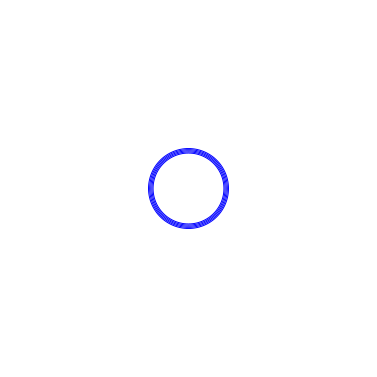

In [13]:
vsk = vsketch.Vsketch()
vsk.size("100mm", "100mm")
vsk.scale("1mm")
vsk.strokeWeight(int_slider.value)
vsk.circle(0, 0, 40*float_slider.value)
show(vsk)

## Interactive functions

This is fine as far as it goes, but it's only marginally "interactive." Ideally, there would be some way to re-run a chunk of code whenever the user changes the widget, instead of having to re-run it manually.

Now we've got everything we need in place to show how to make an interactive interface. The easiest way to do this with IPython widgets involves turning the code that we want to make interactive into a *function* first. If you're not familiar with how Python functions work, I recommend [this tutorial I wrote a while back](http://rwet.decontextualize.com/book/functions/).

Let's start with a simple example. The following cell defines a function that uses vsketch to draw and display a rectangle. The function has one parameter, `size`, which sets the size of the square:

In [14]:
def disp_square(size=40):
    vsk = vsketch.Vsketch()
    vsk.size("100mm", "100mm")
    vsk.scale("1mm")
    vsk.rect(10, 10, size, size)
    show(vsk)

Because the function has a default value, it works without any parameters:

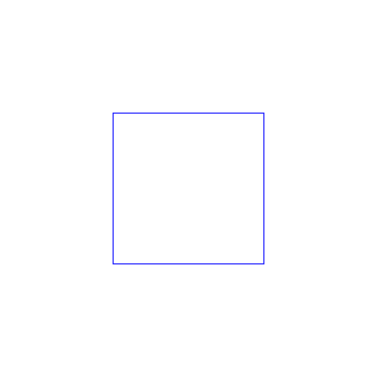

In [15]:
disp_square()

Or you can specify the parameter:

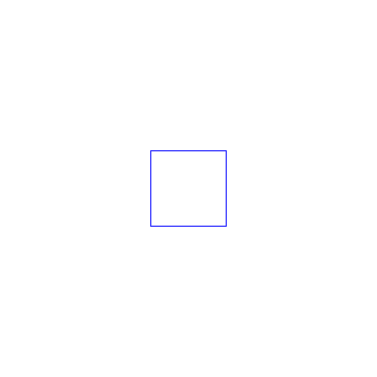

In [16]:
disp_square(size=20)

To make this function interactive, you need to do two things. First: create a widget for the parameter (`IntSlider` in this case). Then call the `widgets.interact()` function. The first parameter of `widgets.interact()` should be the function that you want to call interactively. The remaining (named) parameters map names of your function's parameters to the widget whose value will be passed to that parameter. The cell below does the work—run it, then move the slider to see how it works:

In [17]:
size_slider = widgets.IntSlider(min=0, max=70, value=35)
widgets.interact(disp_square, size=size_slider)

interactive(children=(IntSlider(value=35, description='size', max=70), Output()), _dom_classes=('widget-intera…

<function __main__.disp_square(size=40)>

Here's a more sophisticated example. The `disp_ellipse()` function below draws an ellipse, using values from several parameters to determine fill, stroke width, and size:

In [18]:
def disp_ellipse(filled=False, stroke_weight=10, ellipse_size=20):
    vsk = vsketch.Vsketch()
    vsk.size("100mm", "100mm")
    vsk.scale("1mm")
    if filled:
        vsk.fill(1)
    vsk.strokeWeight(stroke_weight)
    vsk.circle(0, 0, ellipse_size)
    show(vsk)

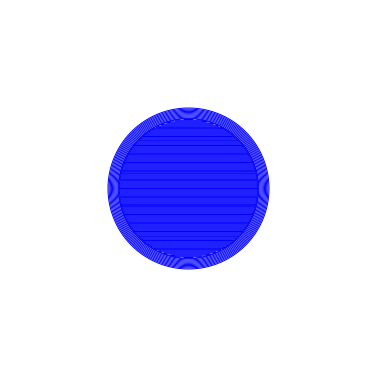

In [19]:
disp_ellipse(True, 10, 40)

In the example below, I make this an interactive function using `widgets.interact()`. Here, I don't bother assigning the widget objects to their own variables, passing them instead directly as values for the named parameters:

In [20]:
widgets.interact(
    disp_ellipse,
    filled=widgets.Checkbox(),
    stroke_weight=widgets.IntSlider(min=1, max=20, value=10),
    ellipse_size=widgets.IntSlider(min=0, max=100, value=20))

interactive(children=(Checkbox(value=False, description='filled'), IntSlider(value=10, description='stroke_wei…

<function __main__.disp_ellipse(filled=False, stroke_weight=10, ellipse_size=20)>

### Slowing it down

You'll notice a little bit of a lag between the movement of the slider and the visual being displayed. This is because vsketch isn't really meant to draw in real time, and sometimes it takes longer for vsketch to render the visual than it takes ipywidgets to call the function again—so the calls get backed up. This is usually fine, but it might be distracting. One way to fix it is to pass `continuous_update=False` to the slider object constructor. This tells ipywidgets to only call the function when the user has released the mouse, instead of whenever the value changes. Here's the same example as above, but using `continuous_update=False`:

In [21]:
widgets.interact(
    disp_ellipse,
    filled=widgets.Checkbox(),
    stroke_weight=widgets.IntSlider(min=1, max=20, value=10, continuous_update=False),
    ellipse_size=widgets.IntSlider(min=0, max=100, value=20, continuous_update=False))

interactive(children=(Checkbox(value=False, description='filled'), IntSlider(value=10, continuous_update=False…

<function __main__.disp_ellipse(filled=False, stroke_weight=10, ellipse_size=20)>

### Seeding random

One potential issue with interactive procedural art is randomness. The ipywidgets `widgets.interact()` function calls your function whenever the slider changes. But if you use random values in that function, each call will produce something drastically different, owing to the different random values. This might be what you want, but it's a little bit unintuitive. As a quick example, consider the function below, which draws *n* ellipses with random fill colors and positions:

In [22]:
def rand_ellipses(n=10):
    vsk = vsketch.Vsketch()
    vsk.size("100mm", "100mm")
    vsk.scale("1mm")
    for i in range(n):
        x = np.random.uniform(100)
        y = np.random.uniform(100)
        size = np.random.uniform(40)
        vsk.circle(x, y, size)
    show(vsk)

Each time you run it, you'll get something different:

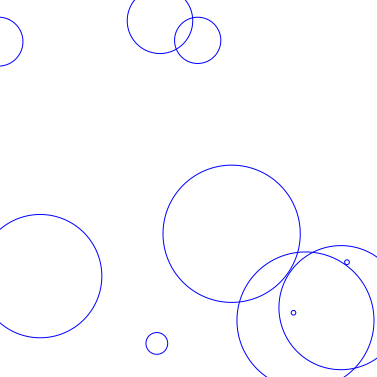

In [23]:
rand_ellipses(10)

Hook this up to `widgets.interact()`:

In [24]:
widgets.interact(rand_ellipses, n=widgets.IntSlider(min=0, max=100, value=10))

interactive(children=(IntSlider(value=10, description='n'), Output()), _dom_classes=('widget-interact',))

<function __main__.rand_ellipses(n=10)>

Each time you move the slider, you get a different set of ellipses! This makes sense, but you might instead want for movements of the slider to simply add/remove ellipses, not create a completely new set. An easy way to do this is to *seed* the random number generator. Seeding the random number generator ensures that the sequence of random numbers produced from the generator will be the same between subsequent runs of the same code. The code in the cell below starts off by calling `np.random.seed()`, which seeds numpy's random number generator. Each time you run the cell, you'll get the same numbers. Try changing the seed:

In [25]:
np.random.seed(103)
for i in range(10):
    print(np.random.uniform())

0.43211120560090255
0.17421526319883063
0.17094368527750203
0.8276322476206412
0.587171260125725
0.459353745644712
0.82268475801786
0.8215481108679935
0.3071202514971392
0.20089437575483526


The function in the cell is like the function above, except it sets the random seed at the top. This ensures that function will always produce the same sequence of random numbers—and therefore ensures that it will always show the same visual output. (But you can change the seed later if you want different output. One of the examples below lets you pick the seed with a widget!)

In [26]:
def rand_ellipses_seed(n=10):
    np.random.seed(12345)
    vsk = vsketch.Vsketch()
    vsk.size("100mm", "100mm", center=False)
    vsk.scale("1mm")
    for i in range(n):
        x = np.random.uniform(100)
        y = np.random.uniform(100)
        size = np.random.uniform(40)
        vsk.circle(x, y, size)
    show(vsk)

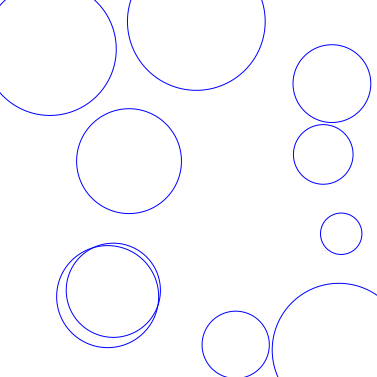

In [27]:
rand_ellipses_seed()

Hooking this up to `widgets.interact()`:

In [28]:
widgets.interact(rand_ellipses_seed,
                 n=widgets.IntSlider(min=0, max=100, value=10))

interactive(children=(IntSlider(value=10, description='n'), Output()), _dom_classes=('widget-interact',))

<function __main__.rand_ellipses_seed(n=10)>

You can see that moving the slider changes only the number of ellipses, not their color and position. Success!

[Python's built-in `random` module has a similar function, `seed()`](https://docs.python.org/3/library/random.html#random.seed). Note that Python's built-in random generator and numpy's random number generator are distinct—seeding one doesn't seed the other!

## Quick interactivity with `interact` decorator

It's very common to want to make a function interactive without a lot of fuss, or to write a function with no other intention than to make it interactive. To make this common use case easier, the ipywidgets library includes a [decorator](https://realpython.com/primer-on-python-decorators/) that you can put in front of a function to make it instantly interactive. The code in the cell below demonstrates. The `disp_tri()` function displays a triangle with the specified stroke width and height. Putting the `@widgets.interact` decorator above it creates an interactive interface for the function:

In [29]:
@widgets.interact
def disp_tri(stroke_weight=10, height=20):
    vsk = vsketch.Vsketch()
    vsk.size("100mm", "100mm")
    vsk.scale("1mm")
    vsk.strokeWeight(stroke_weight)
    vsk.polygon([(40, 20), (20, 20+height), (60, 20+height)])
    show(vsk)

interactive(children=(IntSlider(value=10, description='stroke_weight', max=30, min=-10), IntSlider(value=20, d…

Whoa, super convenient! The drawback of this technique is that ipywidgets has to guess about the minimum, maximum and initial value of the sliders. It has to perform similar guesses for functions with parameters of other types. And sometimes it gets it wrong—as it does in the example above, where it lets us make a negative stroke weight. To fix this, you can pass [widget abbreviations](https://ipywidgets.readthedocs.io/en/latest/examples/Using%20Interact.html#Widget-abbreviations) to the `widgets.interact` decorator, to clarify what kinds of widgets should go along with the function's corresponding parameters:

In [30]:
@widgets.interact(stroke_weight=(1, 20, 1), height=(20, 60))
def disp_tri(stroke_weight=10, height=20):
    vsk = vsketch.Vsketch()
    vsk.size("100mm", "100mm")
    vsk.scale("1mm")
    vsk.strokeWeight(stroke_weight)
    vsk.polygon([(40, 20), (20, 20+height), (60, 20+height)])
    show(vsk)

interactive(children=(IntSlider(value=10, description='stroke_weight', max=20, min=1), IntSlider(value=20, des…

(You can also just pass in widget objects like `widgets.IntSlider()`, etc.)

## Layouts and `interactive_output`

A disadvantage of `widgets.interact` (either as a standalone function or as a decorator) is that it doesn't allow you to control the *layout* of the widgets. The ipywidgets library has a fairly sophisticated set of [classes and functions for styling widgets and arranging them in the notebook](https://ipywidgets.readthedocs.io/en/latest/examples/Widget%20Styling.html). To use the layout functionality, however, you have to use a slightly more sophisticated method for hooking your function up to the widgets: the `widgets.interactive_output()` function. I show an example of this below.

### Layouts with HBox and VBox

The `widgets.HBox()` and `widgets.VBox()` functions produce horizontal and vertical layouts of widgets, respectively. Calling these functions with a list of widgets returns a layout object, which can be displayed like an individual widget. For example, using the widgets we defined back up at the top of the notebook:

In [31]:
hlayout = widgets.HBox([int_slider, float_slider, text_input, checkbox])

In [32]:
display(hlayout)

As you can see, the `HBox` positions the widgets so they're on a horizontal line. The `VBox` layout does the same, except vertically:

In [33]:
vlayout = widgets.VBox([int_slider, float_slider, text_input, checkbox])
display(vlayout)

(This is the default behavior for `widgets.interact()`.) The tricky and useful thing about both `HBox` and `VBox` is that they can be nested: you can put an `HBox` inside of a `VBox` or a `VBox` inside of an `HBox`. The code in the cell below creates an `HBox` with two `VBox`es inside, creating a two-column layout of widgets:

In [34]:
combo_layout = widgets.HBox([
    widgets.VBox([int_slider, float_slider]),
    widgets.VBox([text_input, checkbox]),
])
display(combo_layout)

### Making it interactive with `interactive_output`

Layouts are handy, but they're trickier to hook up to a function that you want to call whenever the widgets are updated. Let's start again with the `disp_tri()` function from above:

In [35]:
@widgets.interact(stroke_weight=(1, 20, 1), height=(20, 60))
def disp_tri(stroke_weight=10, height=20):
    vsk = vsketch.Vsketch()
    vsk.size("100mm", "100mm")
    vsk.scale("1mm")
    vsk.strokeWeight(stroke_weight)
    vsk.polygon([(40, 20), (20, 20+height), (60, 20+height)])
    show(vsk)

interactive(children=(IntSlider(value=10, description='stroke_weight', max=20, min=1), IntSlider(value=20, des…

As an example, I want to make an interface for this function where the widgets are side-by-side, instead of on top of each other. Doing this involves the folowing steps:

* Create the widgets, assigning them to variables
* Create a layout object (`HBox` and/or `VBox`)
* Call the `widgets.interactive_output()` function. The first parameter is the function you want to make interactive; the second is a Python dictionary that maps that function's (named) parameters to the widget that should be used to control that parameter
* Call `display()` with *both* the layout and the return value of `interactive_output` as parameters

The code in the following cell implements this. I've left comments in order to point out the important parts:

In [37]:
# create widgets
stroke_slider = widgets.IntSlider(
    description="stroke weight",
    min=1, max=20, value=1, continuous_update=False)
height_slider = widgets.FloatSlider(
    description="height",
    min=20, max=60, continuous_update=False)

# layout to set these side by side
layout = widgets.HBox([stroke_slider, height_slider])

# make interactive interface: first param is the function,
# second is a dictionary mapping names of function
# parameters to widgets
output = widgets.interactive_output(
    disp_tri,
    {'stroke_weight': stroke_slider, 'height': height_slider}
)

# display both the interface and the output
display(layout, output)

Output()

### Putting it all together

Here's an example that puts it all together. The code in the cell below draws a number of ellipses at random positions, using parameters to determine the number of ellipses, the random distribution to use for their positions, the maximum X and Y sizes of the ellipses, and a random seed value:

In [40]:
def rand_ellipses(n=10, max_size_x=40, max_size_y=40, pos_dist='uniform', seed=12345):
    np.random.seed(seed)
    vsk = vsketch.Vsketch()
    vsk.size("150mm", "150mm", center=False)
    vsk.scale("1mm")
    for i in range(n):
        if pos_dist == 'uniform':
            x = np.random.uniform(150)
            y = np.random.uniform(150)
        else:            
            x = np.random.normal(75, 20)
            y = np.random.normal(75, 20)
        x_size = np.random.uniform(max_size_x)
        y_size = np.random.uniform(max_size_y)
        vsk.ellipse(x, y, x_size, y_size)
    show(vsk)

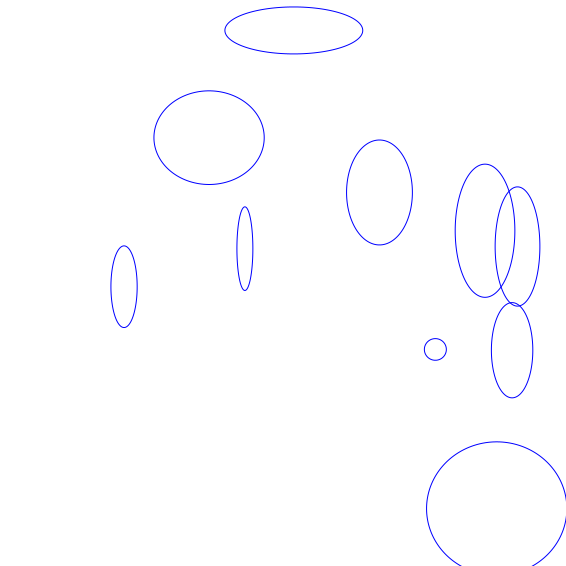

In [41]:
rand_ellipses()

The code in the cell below creates sliders for each of these parameters, then set up a layout with these sliders. Finally, a call to `widgets.interactive_output` associates each of the widgets with the corresponding function parameter. This is a lot of work, but it produces a clean interface:

In [43]:
number_slider = widgets.IntSlider(
    description="circle count", min=0, max=200, value=10,
    continuous_update=False)
maxx_slider = widgets.FloatSlider(
    description="max size X", min=0, max=80, value=40,
    continuous_update=False)
maxy_slider = widgets.FloatSlider(
    description="max size Y", min=0, max=80, value=40,
    continuous_update=False)
pos_dist_select = widgets.Dropdown(
    description="rand dist for position",
    options=["normal", "uniform"],
    value="normal")
seed_input = widgets.BoundedIntText(
    description="random seed",
    min=0,
    max=99999
)
layout = widgets.HBox([
    widgets.VBox([number_slider, maxx_slider, maxy_slider]),
    widgets.VBox([pos_dist_select, seed_input])
])
output = widgets.interactive_output(
    rand_ellipses,
    {
        'n': number_slider,
        'max_size_x': maxx_slider,
        'max_size_y': maxy_slider,
        'pos_dist': pos_dist_select,
        'seed': seed_input
    }
)
display(layout, output)

Output()